In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Circle
import yaml
import glob
plt.style.use('clarke-default')

from ss_ms_utils import *
from cnn_models import *

### Define some parameters of the TPC

In [80]:
in_to_mm = 25.4

pmt_diam = 2.*in_to_mm # mm, PMT diameter
acceptance = 85. # degrees, PMT acceptance angle

radius_pad = 500. # mm, maximum radius at which photons can be collected
tpc_wall_pad = 400. # mm, buffer to ensure light is not lost to TPC edges
max_sep = 500. # mm, maximum separation between MS events considered

radius_tpc = max_sep/2. + radius_pad + tpc_wall_pad # mm

# compute array of PMT positions given the PMT diameter and TPC radius
pmt_pos_array = get_pmt_positions(0, 0, diam=pmt_diam, max_rad=radius_tpc)

with open('data/LRF_{:.0f}mm_{:.0f}deg.yaml'.format(pmt_diam, acceptance), 'r') as f:
    lrf_dict = yaml.safe_load(f)

lrf_params = [lrf_dict['A_fit'], lrf_dict['r0_fit'], lrf_dict['a_fit'], lrf_dict['b_fit'], lrf_dict['alpha_fit']]

### Choose event sites spread across the central region of the TPC
#### Case 1: single-site events

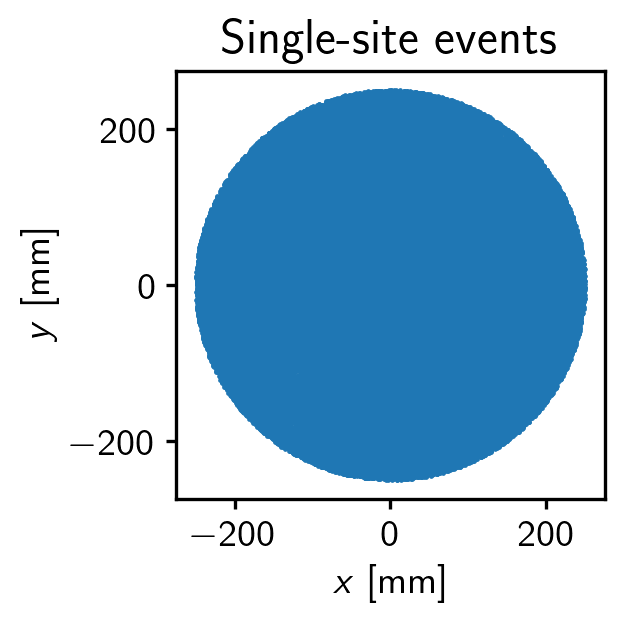

In [86]:
num_events = 50_000 # number of training images for each case
n_photons = 2e1 # number of photons produced in each event *np.ones(num_events)[:, None]

site_ss = get_ss_events(int(num_events*1.8), max_sep)

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.scatter(site_ss[:,0], site_ss[:,1], s=0.5)
ax.set_aspect('equal')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
ax.set_title('Single-site events')
fig.savefig('ss_event_sites.png')

#### Case 2: multi-site events

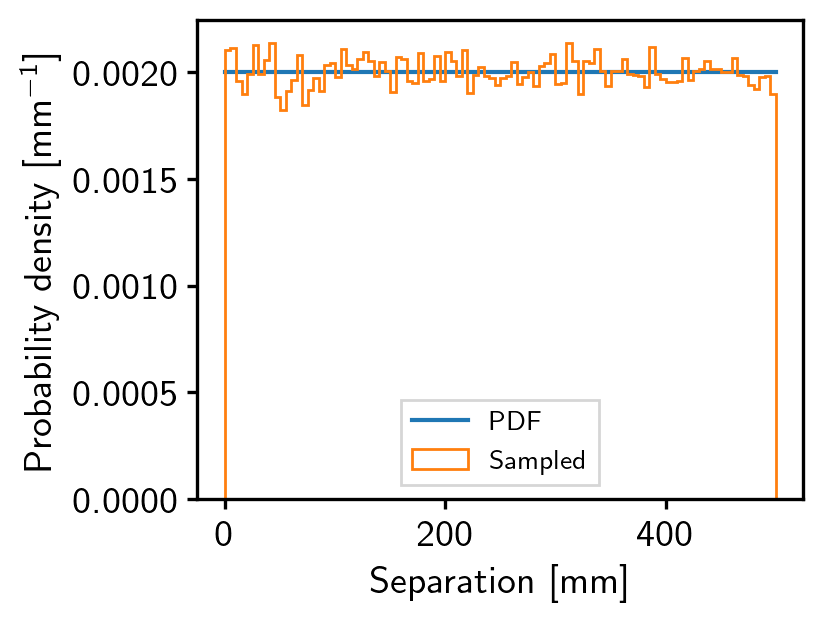

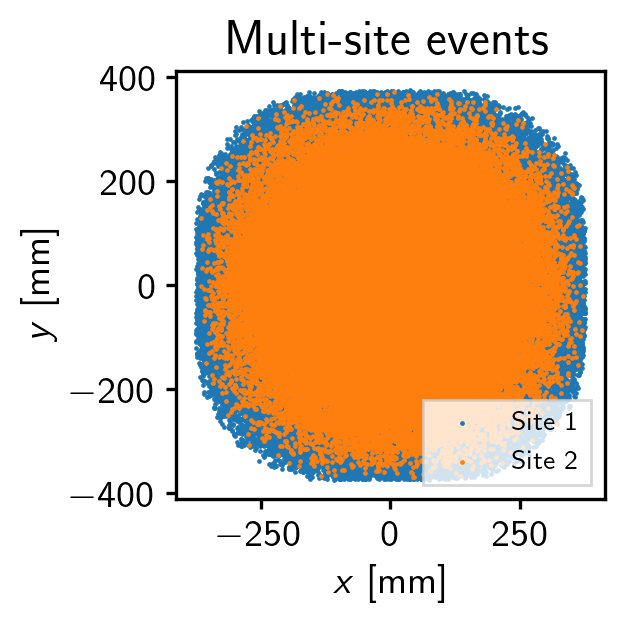

In [87]:
site1, site2 = get_ms_events(int(num_events*1.8), max_sep, uniform_separation)

seps_sampled = np.sqrt(np.sum((site1 - site2)**2, axis=1))
sep_array = np.linspace(0, max_sep, 1000)

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.plot(sep_array, uniform_separation(sep_array, max_sep/2.), label='PDF')
ax.hist(seps_sampled, bins=100, histtype='step', density=True, label='Sampled')
ax.set_xlabel('Separation [mm]')
ax.set_ylabel('Probability density [mm$^{-1}$]')
ax.legend()
fig.savefig('sep_dist_exp.png')

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.scatter(site1[:,0], site1[:,1], s=0.5, label='Site 1')
ax.scatter(site2[:,0], site2[:,1], s=0.5, label='Site 2')
ax.set_aspect('equal')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
ax.set_title('Multi-site events')
ax.legend()
fig.savefig('ms_event_sites.png')

### Compute the number of counts on each PMT

In [88]:
# single site
r_points = np.sqrt(np.sum((site_ss[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
mean_counts = n_photons*lrf(r_points/10., *lrf_params)
det_counts_ss = np.random.poisson(mean_counts)

# multi site
r_points_1 = np.sqrt(np.sum((site1[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
r_points_2 = np.sqrt(np.sum((site2[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
mean_counts_1 = 0.5*n_photons*lrf(r_points_1/10., *lrf_params)
mean_counts_2 = 0.5*n_photons*lrf(r_points_2/10., *lrf_params)
det_counts_ms = np.random.poisson(mean_counts_1 + mean_counts_2)

### Plot sample PMT hit patterns

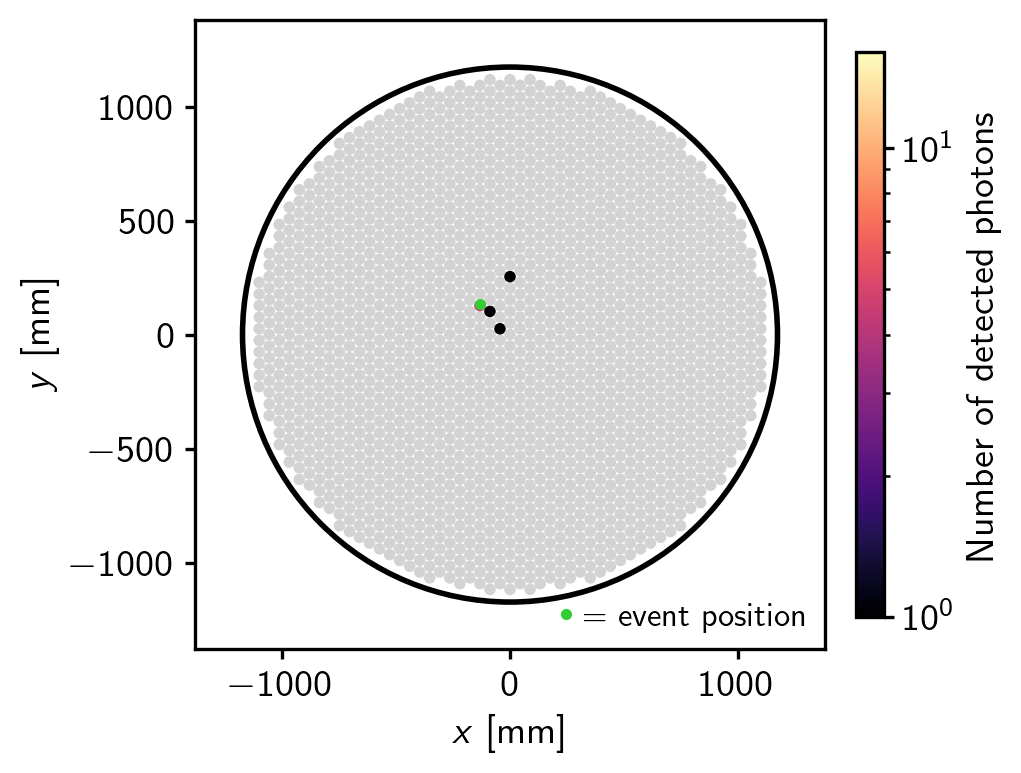

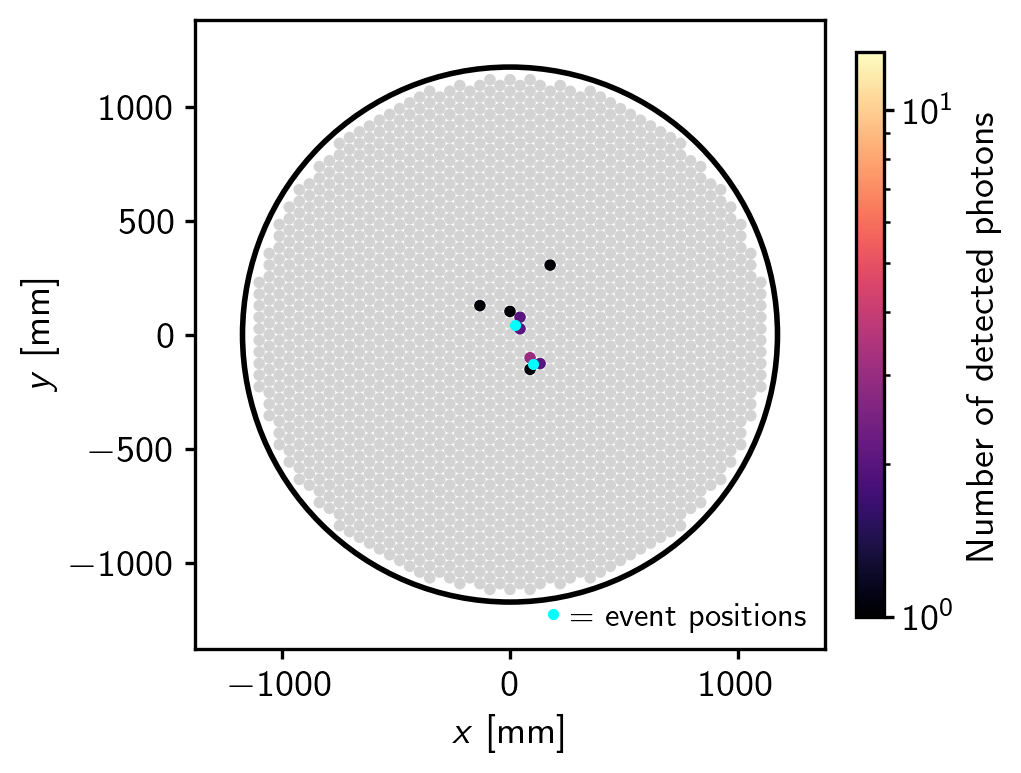

In [89]:
fig, ax = plot_ss_event(site_ss, det_counts_ss, 0, pmt_pos_array, pmt_diam, radius_tpc)
fig.savefig('hit_pattern_ss.png')
fig, ax = plot_ms_event(site1, site2, det_counts_ms, 0, pmt_pos_array, pmt_diam, radius_tpc)
fig.savefig('hit_pattern_ms.png')

### Build the training images

In [ ]:
image_width = max_sep + 2.*radius_pad
image_height = 2.*radius_pad

images_ms, pmt_indices = images_from_events(det_counts_ms, pmt_pos_array, pmt_diam, image_width, image_height)
images_ss, pmt_indices_ss = images_from_events(det_counts_ss, pmt_pos_array, pmt_diam, image_width, image_height)

/Users/clarke/Documents/Research/Migdal/ss_ms_paper/ss_ms_utils.py:368: RuntimeWarning: invalid value encountered in divide
  counts_images.append(counts_image/np.sum(counts_image))


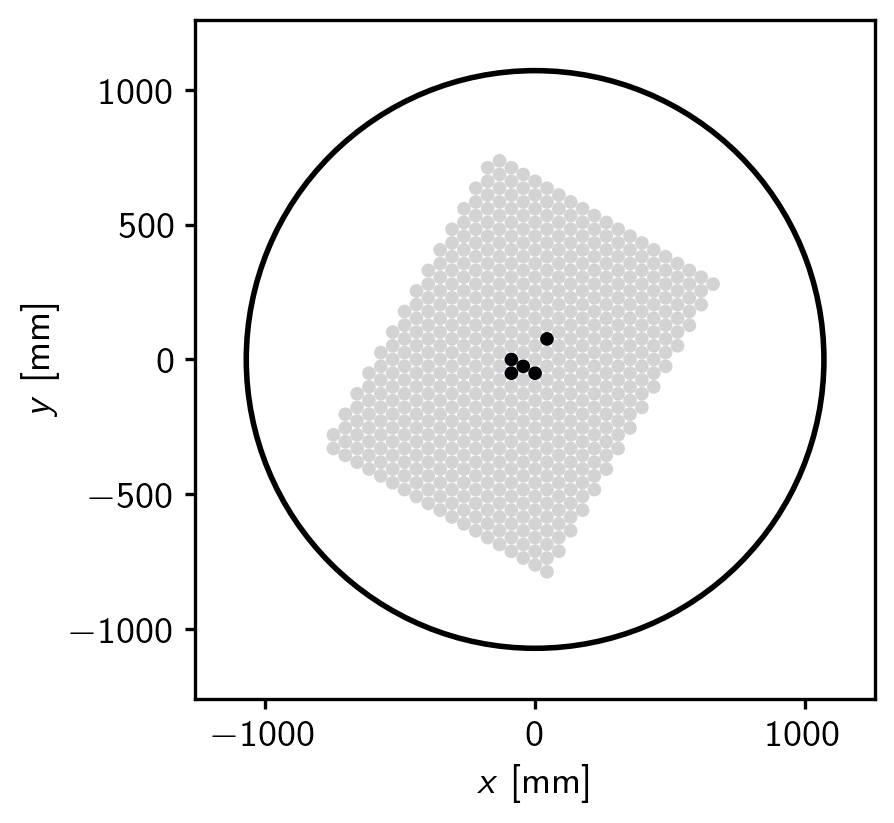

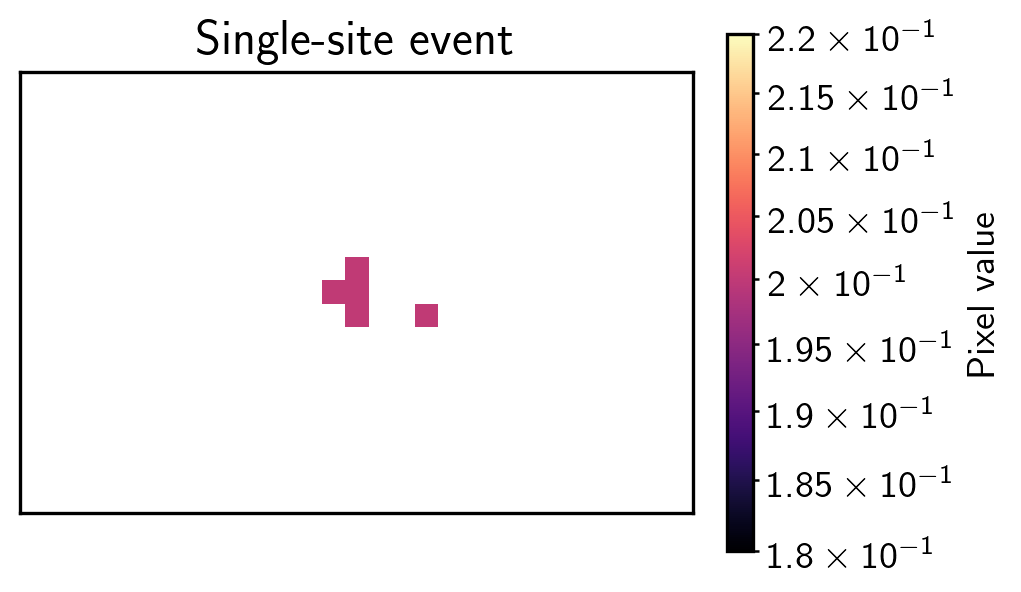

In [74]:
event_id = 0

fig, _ = plot_selected_pmts(det_counts_ss, pmt_indices_ss, event_id, pmt_pos_array, pmt_diam, radius_tpc)
fig.savefig('ss_selected_pmts.png')

fig, ax = plt.subplots(figsize=(5, 4), layout='constrained')
im = ax.imshow(images_ss[event_id].T, origin='lower', norm=mcolors.LogNorm(), cmap='magma')
fig.colorbar(im, shrink=0.66, label='Pixel value')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Single-site event')
fig.savefig('ss_sample_image.png')

In [75]:
from tensorflow.keras import callbacks

# Example usage on CIFAR-10-sized inputs:
model = ResNet20(input_shape=(29,19,1), num_classes=1)
model.summary()
# model.fit(x_train, y_train, batch_size=128, epochs=200,
#           validation_data=(x_test, y_test))

Model: "ResNet20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 29, 19, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 29, 19,    │        144 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19,    │         64 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_72 (ReLU)     │ (None, 29, 19,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19,    │         64 │ re_lu_72[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_73 (ReLU)     │ (None, 29, 19,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 29, 19, 8) │      1,152 │ re_lu_73[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_81[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_74 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 29, 19, 8) │        128 │ re_lu_72[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_74[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_83[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 29, 19, 8) │          0 │ conv2d_82[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ add_32[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_75 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_75[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 29, 19, 8) │         32 │ conv2d_84[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_76 (ReLU)     │ (None, 29, 19, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 29, 19, 8) │        576 │ re_lu_76[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 68,817 (268.82 KB)

 Trainable params: 68,001 (265.63 KB)

 Non-trainable params: 816 (3.19 KB)

### Scramble data and divide into training and validation

In [76]:
truth_ms = np.zeros(images_ms.shape[0])
truth_ss = np.ones(images_ss.shape[0])

images_all = np.vstack((images_ss, images_ms))
truth_all = np.hstack((truth_ss, truth_ms)) #.T

permutation = np.random.permutation(truth_all.shape[0])

images_scrambled = images_all[permutation, ...]
truth_scrambled = truth_all[permutation, ...]

validation_split = 0.2

images_training = images_scrambled[:int(-validation_split*2*num_events)]
truth_training = truth_scrambled[:int(-validation_split*2*num_events)]
images_validation = images_scrambled[int(-validation_split*2*num_events):]
truth_validation = truth_scrambled[int(-validation_split*2*num_events):]
indices_validation = permutation[int(-validation_split*2*num_events):]

np.savez('data/images_{:.0e}_events_{:.0e}_photons.npz'.format(num_events, n_photons), images_training=images_training, \
         truth_training=truth_training, images_validation=images_validation, truth_validation=truth_validation, \
         indices_validation=indices_validation)

### Train the CNN

Epoch 1/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - AUC: 0.8084 - acc: 0.7604 - loss: 0.4811 - val_AUC: 0.8074 - val_acc: 0.7482 - val_loss: 0.4605 - learning_rate: 1.0000e-04
Epoch 2/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - AUC: 0.8279 - acc: 0.7875 - loss: 0.4450 - val_AUC: 0.8270 - val_acc: 0.7883 - val_loss: 0.4403 - learning_rate: 1.0000e-04
Epoch 3/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - AUC: 0.8309 - acc: 0.7923 - loss: 0.4370 - val_AUC: 0.8258 - val_acc: 0.7833 - val_loss: 0.4368 - learning_rate: 1.0000e-04
Epoch 4/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 45s 67ms/step - AUC: 0.8334 - acc: 0.7946 - loss: 0.4301 - val_AUC: 0.8296 - val_acc: 0.7917 - val_loss: 0.4330 - learning_rate: 1.0000e-04
Epoch 5/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - AUC: 0.8350 - acc: 0.7962 - loss: 0.4253 - val_AUC: 0.8321 - val_acc: 0.7968 - val_loss: 0.4332 - learning_rate: 1.0000e-04
Epoch 6/30
680/680 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - AUC: 0.8374 - acc: 0.7989 - loss: 0.4211 - v

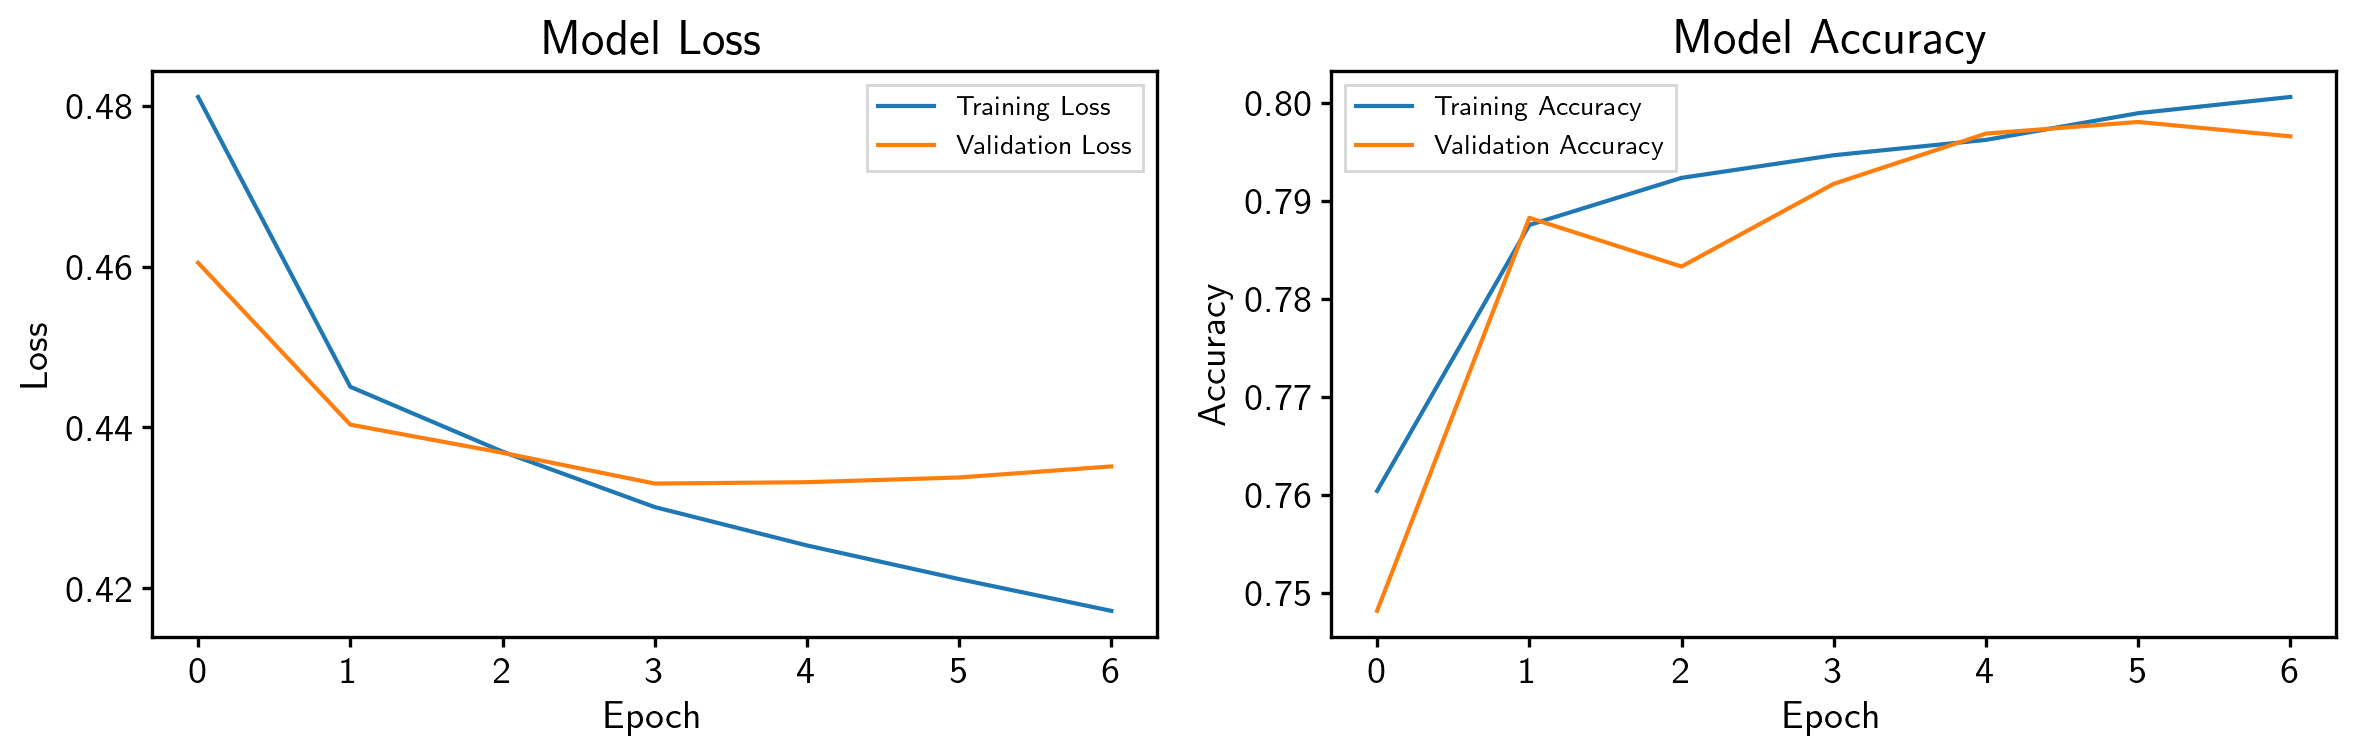

In [77]:
lr_scheduler = callbacks.LearningRateScheduler(scheduler)
earlystopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(images_training, truth_training,
    batch_size=128,
    epochs=30,
    callbacks=[lr_scheduler, earlystopping],
    validation_data=(images_validation, truth_validation)
)

model.save('data/' + model.name + '_{:.0f}_events_{:.0e}_photons.keras'.format(num_events, n_photons))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('cnn_training.png')

### Plot performance on the validation data

Youden optimal cut keeps 88.2% of signal events and removes 71.7% of background events.


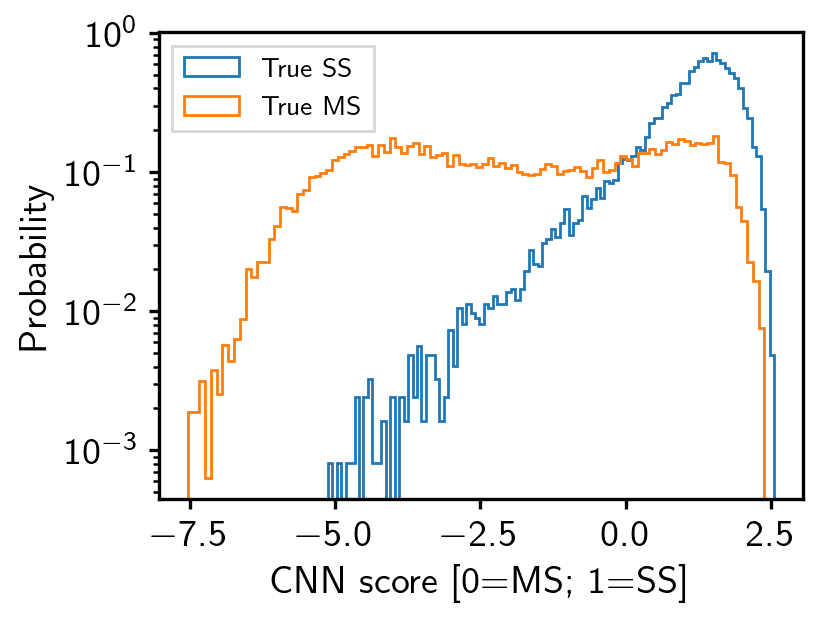

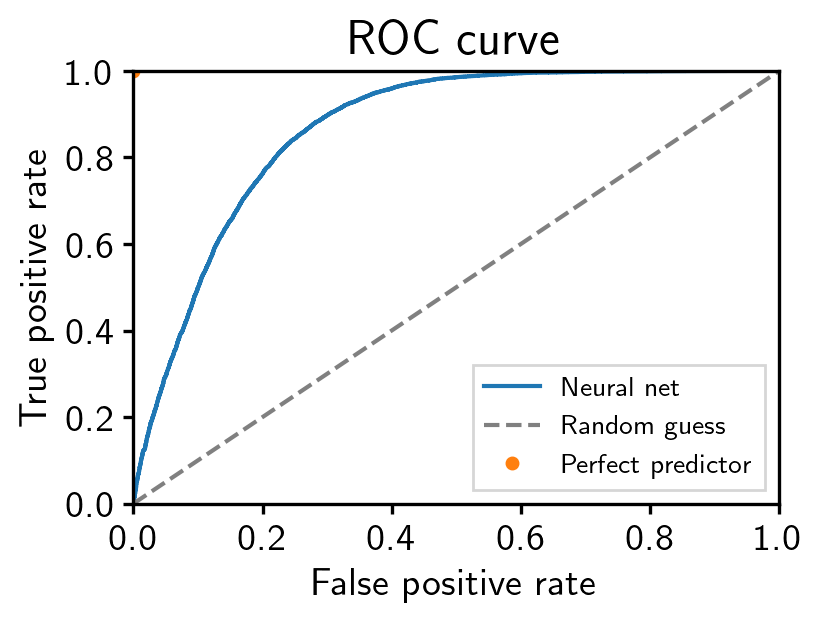

In [78]:
# get the validation data
ss_validation = images_all[indices_validation][indices_validation < images_ss.shape[0]]
ms_validation = images_all[indices_validation][indices_validation >= images_ss.shape[0]]

# run the validation images through the trained model
ss_predictions = model(ss_validation[:,:,:,None], training=False)[:,0].numpy()
ms_predictions = model(ms_validation[:,:,:,None], training=False)[:,0].numpy()

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.hist(ss_predictions, bins=100, histtype='step', density=True, label='True SS')
ax.hist(ms_predictions, bins=100, histtype='step', density=True, label='True MS')
ax.set_yscale('log')
ax.set_xlabel('CNN score [0=MS; 1=SS]')
ax.set_ylabel('Probability')
ax.legend()
fig.savefig('cnn_score_dists.png')

y_pred = np.array(np.array(model(images_validation))[:,0])
y_true = np.copy(truth_validation)

sorted_indices = np.argsort(-y_pred)
y_true_sorted = y_true[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

P = np.sum(y_true)
N = len(y_true) - P

tpr = np.cumsum(y_true_sorted)/P
fpr = np.cumsum(1 - y_true_sorted)/N

youden = tpr - fpr - 1
opt_ind = np.argmax(youden)

print('Youden optimal cut keeps {:.1f}% of signal events and removes {:.1f}% of background events.'\
      .format(100*tpr[opt_ind], 100*(1. - fpr[opt_ind])))

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.plot(fpr, tpr, label='Neural net')
ax.plot([0, 1], [0, 1], ls='--', color='grey', label='Random guess')
ax.plot([0], [1], marker='o', ls='none', ms=4, label='Perfect predictor')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('ROC curve')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(loc='lower right')
fig.savefig('cnn_roc.png')

/Users/clarke/Documents/Research/Migdal/ss_ms_paper/ss_ms_utils.py:368: RuntimeWarning: invalid value encountered in divide
  counts_images.append(counts_image/np.sum(counts_image))


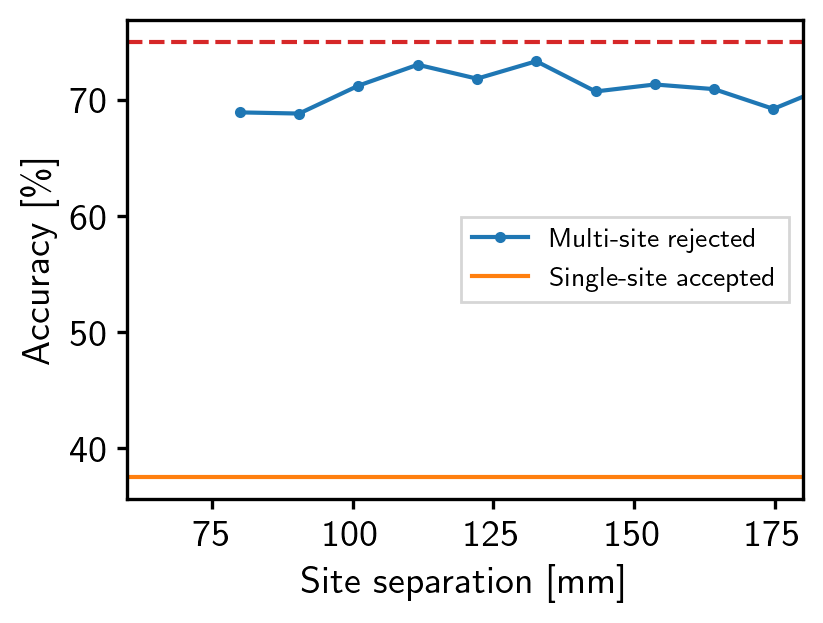

In [79]:
def make_ms_events(n_events, this_sep):
    angle = np.random.uniform(0, 2.*np.pi, n_events)
    site1 = np.zeros((2, n_events)) #np.array((-this_sep*np.cos(angle)/2., -this_sep*np.sin(angle)/2.)) \
            #+ pmt_diam*np.random.rand(2*n_events).reshape((2, n_events))
    site2 = site1 + np.array((this_sep*np.cos(angle), this_sep*np.sin(angle)))
    return site1.T, site2.T

# thresh = y_pred[sorted_indices[opt_ind]]
acc_test = []
seps = np.linspace(80, 280, 20)

site_test = get_ss_events(1000, pmt_diam)

r_points = np.sqrt(np.sum((site_test[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
mean_counts = n_photons*lrf(r_points/10., *lrf_params)
det_counts_test = np.random.poisson(mean_counts)
images_test, _ = images_from_events(det_counts_test, pmt_pos_array, pmt_diam, image_width, image_height)
preds = model(images_test[:,:,:,None], training=False)[:,0].numpy()
thresh = np.median(preds)
kept = np.sum(preds > thresh)

for this_sep in seps:
    site1_test, site2_test = make_ms_events(1000, this_sep)
    
    r_points_1 = np.sqrt(np.sum((site1_test[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
    r_points_2 = np.sqrt(np.sum((site2_test[..., None] - pmt_pos_array.T[None, ...])**2, axis=1))
    mean_counts_1 = 0.5*n_photons*lrf(r_points_1/10., *lrf_params)
    mean_counts_2 = 0.5*n_photons*lrf(r_points_2/10., *lrf_params)
    det_counts_test = np.random.poisson(mean_counts_1 + mean_counts_2)

    images_test, _ = images_from_events(det_counts_test, pmt_pos_array, pmt_diam, image_width, image_height)

    preds = model(images_test[:,:,:,None], training=False)[:,0].numpy()

    acc_test.append(np.sum(preds < thresh))

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.plot(seps, np.array(acc_test)/1000*1e2, marker='.', label='Multi-site rejected')
ax.axhline(kept/1000*1e2, color='C1', label='Single-site accepted')
ind = np.argmin(np.abs(np.interp(np.linspace(0, 280, 1000), seps, np.array(acc_test)/1000*1e2) - 84.))
ax.axvline(np.linspace(0, 280, 1000)[ind], ls='--', color='C2')
ax.axhline(np.interp(np.linspace(0, 280, 1000)[ind], seps, np.array(acc_test)/1000*1e2), ls='--', color='C3')
ax.set_xlabel('Site separation [mm]')
ax.set_ylabel(r'Accuracy [\%]')
ax.set_xlim([60, 180])
ax.legend()
fig.savefig('cnn_acc_vs_sep.png')

/Users/clarke/Documents/Research/Migdal/ss_ms_paper/ss_ms_utils.py:41: RuntimeWarning: divide by zero encountered in power
  return A*np.exp(-a*rho/(1 + rho**(1 - alpha)) - b/(1 + rho**(-alpha)))


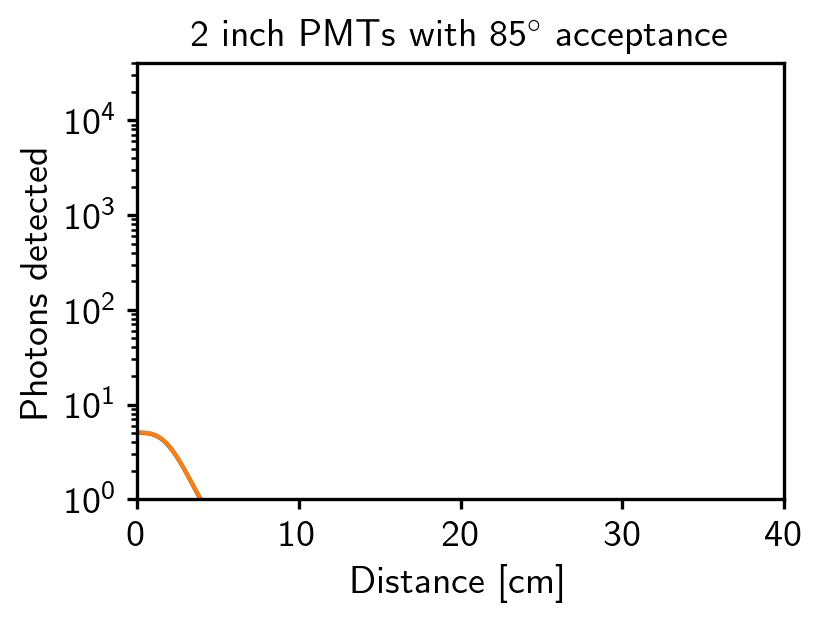

In [60]:
lrf_2inch_85deg_g4 = [2537.17/1e4*n_photons, 3.96, 0.88, 2.38, 3.16]
lrf_2inch_70deg_g4 = [2596.87/1e4*n_photons, 4.39, 4.62, -0.08, 2.86]

with open('data/LRF_51mm_85deg.yaml'.format(pmt_diam, acceptance), 'r') as f:
    lrf_dict = yaml.safe_load(f)
lrf_2inch_85deg_chroma = [n_photons*lrf_dict['A_fit'], lrf_dict['r0_fit'], lrf_dict['a_fit'], \
                          lrf_dict['b_fit'], lrf_dict['alpha_fit']]

with open('data/chroma/LRF_51mm_70deg.yaml', 'r') as f:
    lrf_dict = yaml.safe_load(f)
lrf_2inch_70deg_chroma = [n_photons*lrf_dict['A_fit'], lrf_dict['r0_fit'], lrf_dict['a_fit'], \
                          lrf_dict['b_fit'], lrf_dict['alpha_fit']]

rad_array = np.linspace(0, 40, 1000)

fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_85deg_chroma))
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_85deg_g4))
ax.set_ylim([1e0, 4e4])
ax.set_xlim([0, 40])
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Photons detected')
ax.set_title(r'2 inch PMTs with 85$^\circ$ acceptance', fontsize=14)
fig.savefig('g4_chroma_comparison_2inch_85deg.png')

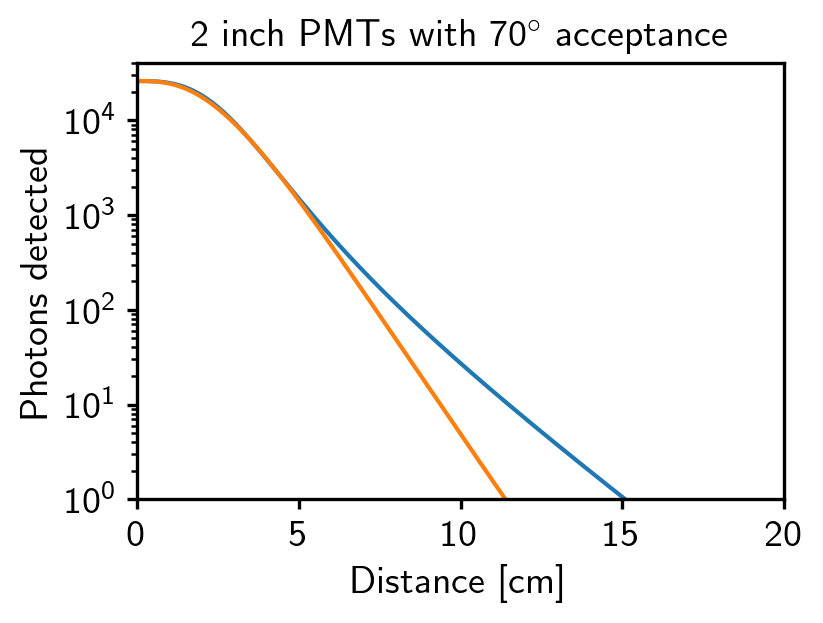

In [42]:
fig, ax = plt.subplots(figsize=(4, 3), layout='constrained')
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_70deg_chroma), label='Chroma')
ax.semilogy(rad_array, lrf(rad_array, *lrf_2inch_70deg_g4), label='Geant4')
ax.set_ylim([1e0, 4e4])
ax.set_xlim([0, 20])
ax.set_xlabel('Distance [cm]')
ax.set_ylabel('Photons detected')
ax.set_title(r'2 inch PMTs with 70$^\circ$ acceptance', fontsize=14)
fig.savefig('g4_chroma_comparison_2inch_70deg.png')